**MDS7203 Modelos Generativos Profundos, Primavera 2023**

# Laboratorio 2: Modelo de lenguaje auto-regresivo

**Profesor**: Felipe Tobar, **Auxiliares**: Cristóbal Alcázar, Camilo Carvajal Reyes, **Ayudante**: Joaquín Barceló.

**Fecha de entrega**: viernes 29 de septiembre 2023

**Nombre: Arturo Lazcano**

**Instrucciones**: El presente notebook contiene enunciado e instrucciones para la realización del laboratorio. Usted deberá completar los códigos (en este archivo o en una copia del mismo) donde se le pida hacerlo. Usted deberá entregar el notebook con sus respuestas, cumpliendo lo siguiente:

- Los comentarios en código deben ser concisos pero claros. No se evaluarán sub-preguntas donde solo exista código sin comentarios pertinentes.
- El código debe ser ordenado y ejectuable. No se evaluarán notebooks o scripts que generen errores en su ejecución. Se aconseja resetear la kernel y corroborar la correcta execución de todas las celdas antes de ejecutar el entrenamiento de su modelo.
- Si bien se aconseja el uso de internet y otras herramientas para asistir su trabajo, asi como discusiones con el ED y estudiantes, el código que entregue debe ser de su autoría.

El objetivo del laboratorio será implementar, desde casi cero, un modelo de lenguaje estilo GPT, i.e., basado en el uso de un bloque "decoder" de la arquitectura Transformer (como se muestra en la imagen a continuación). Este tipo de modelos es un ejemplo de modelo auto-regresivo y que ha tenido gran relevancia en el último tiempo.

In [36]:
from IPython.display import Image
Image(url='https://i.stack.imgur.com/bWnx0.png')

Algunos links útiles:

* [Language Models are Unsupervised Multitask Learners](https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf)
* [GPT2, original blog post](https://openai.com/research/better-language-models)

### Resumen de preguntas

- [ ] a) (0,5 ptos.) Definición de diccionarios para vocabulario

- [ ] b) (bonus) Utilización de embeddings previo a la normalización

- [ ] c) (bonus) Escalamiento por $1/\sqrt{d_k}$.

- [ ] d) (1.5 ptos.) Creación de clase `Head`.

- [ ] e) (0.75 pto.) Implementación de clase `FeedForward`.

- [ ] f) (0.5 ptos.) Relación entre hiper-parámetros n_head y head_size.

- [ ] g) (0.75 ptos.) Forward pass en `DecoderBlock`.

- [ ] h) (1 pto.) Implementación clase `GPTLM`.

- [ ] i) (1 pto.) Training loop.

- [ ] j) (bonus) Comparar modelo con Baseline.

In [50]:
# Librerías del Lab 2
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import math

Características de la GPU, si es que está disponible.

In [2]:
!nvidia-smi

Fri Sep 29 13:19:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Corpus 📖

Escoja uno de los dos datasets:
- shakespeare.txt: concatenación de obras de shakespeare, ~ 1 millon de caracteres
- cabromagico.txt: concatenación de los libros de Harry Potter, ~ 6 millones de caracteres

Escoja en base a sus gustos y capacidades de cómputo.

In [3]:
# Si usan colab, descargar dataset desde repo GAMES descomentando una de las siguientes lineas:
!wget https://raw.githubusercontent.com/GAMES-UChile/Curso-Modelos-Generativos-Profundos/main/labs/data/shakespeare.txt
# !wget https://raw.githubusercontent.com/GAMES-UChile/Curso-Modelos-Generativos-Profundos/main/labs/data/cabromagico.txt

--2023-09-29 13:19:15--  https://raw.githubusercontent.com/GAMES-UChile/Curso-Modelos-Generativos-Profundos/main/labs/data/shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-09-29 13:19:15 (18.2 MB/s) - ‘shakespeare.txt’ saved [1115394/1115394]



In [4]:
# Selecciona el corpus a su gusto
filename = 'shakespeare.txt'
#filename = 'cabromagico.txt'

with open(filename, 'r', encoding='utf-8') as file:
    text = file.read()

print(f"Tamaño del corpus ({filename}): {len(text):,} caracteres")

Tamaño del corpus (shakespeare.txt): 1,115,394 caracteres


In [5]:
# caracteres que se usarán a modo de formar potenciales palabras (notar que está el \n -> salto de línea)
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


> a) (0.5 ptos.) Dada una lista de ordenada de caracteres, defina:
> - stoi: un diccionario caracter -> índice
> - itos: un diccionario índice -> caracter
> Con lo anterior, defina dos funciones encode y decode que tomen un string y una lista de índices respectivamente y devuelvan una lista de índices y un string según corresponda.

In [6]:
# --------------------------------------------

stoi = {k: v for v, k in enumerate(chars)}
itos = {y: x for x, y in stoi.items()}

# encoder: toma un string, devuelve una lista de índices
encode = lambda s: [stoi[x] for x in s]

# decoder: toma una lista de índices, devuelve un string
decode = lambda l: ''.join([itos[x] for x in l])

# --------------------------------------------

In [7]:
if filename == 'shakespeare.txt':
    assert encode('hola, que tal?') == [46, 53, 50, 39, 6, 1, 55, 59, 43, 1, 58, 39, 50, 12], 'Verifica que el output entregue una lista de enteros'
    assert decode(encode('hola, que tal?')) == 'hola, que tal?', 'Debe ser un string'
elif filename == 'cabromagico.txt':
    assert encode('hola, que tal?') == [73, 80, 77, 66, 14, 4, 82, 86, 70, 4, 85, 66, 77, 33], 'Verifica que el output entregue una lista de enteros'
    assert decode(encode('hola, que tal?')) == 'hola, que tal?', 'Debe ser un string'
else:
    print('Estas usando un filename distinto para construir el corpus!\nSi estas explorando otro corpus esta bien!\nRecuerda verificar que la funcionalidad esta correcta con shakespear o cabromagico.')

Nuestro modelo no entiende el lenguaje directamente, sino que los representa como números. Pasamos el corpus completo a su representación de enteros, usando el `stoi` (aka _string-to-index_).

In [8]:
# dataset a tensor
data = torch.tensor(encode(text), dtype=torch.long)
data.shape

torch.Size([1115394])

In [9]:
# ejemplo de caracteres con su representación
N=100
print(f"Texto con los primeros {N} caracteres:\n----------------------------------------------\n")
print(text[:N])
print("\n----------------------------------------------\nSu representación como tensor de PyTorch...\n")
print(data[:N])

Texto con los primeros 100 caracteres:
----------------------------------------------

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You

----------------------------------------------
Su representación como tensor de PyTorch...

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


## 2. Separar el dataset 🔨 y 🎓

In [10]:
# definir % de train y validación
n = int(0.9 * len(data))  # 90%
train_data = data[:n]
val_data = data[n:]
print(f"--> Tamaño del corpus de entrenamiento: {len(train_data):,} ({(train_data.shape[0] / data.shape[0]):.2f}) caracteres")
print(f"--> Tamaño del corpus de validación: {len(val_data):,} ({(val_data.shape[0] / data.shape[0]):.2f}) caracteres")

--> Tamaño del corpus de entrenamiento: 1,003,854 (0.90) caracteres
--> Tamaño del corpus de validación: 111,540 (0.10) caracteres


Sobre la mécanica de datos y etiquetas,

* Accedemos a los datos a partir de "fragmentos contextuales"; esto es un bloque de texto en representación númerica de tamaño `block_size`
* El modelo es semi-supervisado, es decir, búscamos entrenar un modelo de tal forma que dado ${x}_{i:j}$ _tokens_, vamos a predecir el siguiente _token_ $x_{j+1}$
* Las etiquetas emergen del mismo bloque contextual moviendo la ventana con un _offset_ de 1.

Por ejemplo, dado un bloque de tamaño 8,


In [11]:
# ejemplo de bloque contextual
block_size = 13
print(f"Una bloque contextual (X, Y) será:\n")
print(f"X: {[x.item() for x in data[:block_size]]}")
print(f"  --> decode(X): {decode([x.item() for x in data[:block_size]])}")
print('------------------------------------')
print(f"Y: {[x.item() for x in data[1:block_size+1]]}")
print(f"  --> decode(Y): {decode([y.item() for y in data[1:block_size+1]])}")

Una bloque contextual (X, Y) será:

X: [18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52]
  --> decode(X): First Citizen
------------------------------------
Y: [47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10]
  --> decode(Y): irst Citizen:


Sin embago, dentro de cada bloque contextual ocupamos la información de manera autoregresiva, generando múltiple observaciones a partir de este...

In [12]:
# ejemplos de inputs con target respectivos
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"Cuando el input es {context} el target es: {target}")

Cuando el input es tensor([18]) el target es: 47
Cuando el input es tensor([18, 47]) el target es: 56
Cuando el input es tensor([18, 47, 56]) el target es: 57
Cuando el input es tensor([18, 47, 56, 57]) el target es: 58
Cuando el input es tensor([18, 47, 56, 57, 58]) el target es: 1
Cuando el input es tensor([18, 47, 56, 57, 58,  1]) el target es: 15
Cuando el input es tensor([18, 47, 56, 57, 58,  1, 15]) el target es: 47
Cuando el input es tensor([18, 47, 56, 57, 58,  1, 15, 47]) el target es: 58
Cuando el input es tensor([18, 47, 56, 57, 58,  1, 15, 47, 58]) el target es: 47
Cuando el input es tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47]) el target es: 64
Cuando el input es tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64]) el target es: 43
Cuando el input es tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43]) el target es: 52
Cuando el input es tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52]) el target es: 10


Por lo tanto, cada bloque contextual, genera un número de observaciones igual a su tamaño.

En términos de _batches_, podemos procesar en paralelo, múltiples bloques contextuales. Lo importante es que cada bloque contextual es independiente, y no hay computo que ocurra a nivel transversal, sino paralelo entre estos. No se mezclan las secuencias autoregresivas de cada contexto.

In [13]:
# colocar seed como su RUT
torch.manual_seed(20470051)
batch_size = 4
block_size = 8  # largo de ventana máximo para considerar en la precisión
# Estos parámetros se re-definirán para el entrenamiento final

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"Cuando el input es {context.tolist()} el target: {target}")

inputs:
torch.Size([4, 8])
tensor([[52, 42,  1, 40, 47, 42,  1, 46],
        [57, 58, 11,  1, 39, 52, 42,  6],
        [ 1, 39, 52, 42,  0, 50, 53, 60],
        [10,  0, 21, 44,  1, 58, 46, 43]])
targets:
torch.Size([4, 8])
tensor([[42,  1, 40, 47, 42,  1, 46, 43],
        [58, 11,  1, 39, 52, 42,  6,  1],
        [39, 52, 42,  0, 50, 53, 60, 43],
        [ 0, 21, 44,  1, 58, 46, 43, 63]])
----
Cuando el input es [52] el target: 42
Cuando el input es [52, 42] el target: 1
Cuando el input es [52, 42, 1] el target: 40
Cuando el input es [52, 42, 1, 40] el target: 47
Cuando el input es [52, 42, 1, 40, 47] el target: 42
Cuando el input es [52, 42, 1, 40, 47, 42] el target: 1
Cuando el input es [52, 42, 1, 40, 47, 42, 1] el target: 46
Cuando el input es [52, 42, 1, 40, 47, 42, 1, 46] el target: 43
Cuando el input es [57] el target: 58
Cuando el input es [57, 58] el target: 11
Cuando el input es [57, 58, 11] el target: 1
Cuando el input es [57, 58, 11, 1] el target: 39
Cuando el input es [57

Lo que recibirá la red como _input_ será:

In [14]:
xb # input

tensor([[52, 42,  1, 40, 47, 42,  1, 46],
        [57, 58, 11,  1, 39, 52, 42,  6],
        [ 1, 39, 52, 42,  0, 50, 53, 60],
        [10,  0, 21, 44,  1, 58, 46, 43]])

## 3. Baseline

Creamos un modelo base clásico, para luego compararlo con nuestro Transformer.

In [17]:
torch.manual_seed(20470051)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # cada token lee sucesivamente los logits para el token siguiente de una lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx y targets son ambos tensores de tamaño (B,T) con elementos enteros
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx es un arreglo (B, T) de indices del contexto actual
        for _ in range(max_new_tokens):
            # obtener predicciones
            logits, loss = self(idx)
            # concentrarse en el último paso
            logits = logits[:, -1, :]  # se convierte en (B, C)
            # aplicamos softmax para obtener probabilidades
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # samplear de la distribución
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # agregar el índice de la muestra a la secuencia actual
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# definir modelo y probarlo (sin entrenar)
m = BigramLanguageModel(vocab_size)

# si xb, yb están en cuda descomentar estas líneas
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#m.to(device)

logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))  # ---> cpu
#print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=100)[0].tolist()))  # ---> gpu
print('------------------ \n resultado malaso el de arriba jaja')

torch.Size([32, 65])
tensor(4.6607, grad_fn=<NllLossBackward0>)

HGtECvzIt$Q 3rkfe;zhQwRKLs uDtuvVZjgEO:xuhJ FcIYRNLhkLduHbJbRzqV3?x-TP,ZUYhkPyzqpFY vqqheSRYlDhMGUYg
------------------ 
 resultado malaso el de arriba jaja


## 4. Self-attention

En la sección anterior, vimos que cada _token_ toma una representación vectorial llamada _embeddings_.

Nuestro corpus contiene $65$ caracteres únicos con un _embedding_ asociado a cada _token_. La idea de representar el lenguaje en términos de tokens, y estos a su vez en vectores, es que podemos aprender estas representaciones vectoriales a partir de los datos. Sin embargo, la representación es única, y muchas veces un mismo _token_ puede tener distintos significados según su contexto. Por ejemplo:
1. "Te banco a morir!"
2. "El banco está abierto hasta las dos."

En ambas oraciones anteriores, el token `banco` tiene un significado distinto. Se espera entonces que la representación de ese token sea distinta en ambos casos y eso lo logramos con la influencia de los tokens presentes en el mismo contexto.

La idea principal de _self-attention_ es utilizar la secuencia de _embeddings_ dentro de un contexto para computar un promedio ponderado a partir de estos. Dado una secuencia de _embeddings_ de _tokens_ $x_1, \dots, x_n$, el mecanismo de _self-attention_ (o auto-atención) produce una nueva secuencia de _embeddings_ $x'_1, \dots, x'_n$, donde cada $x'_i$ es una combinación lineal de todos los $x_j$:

$$
x'_i = \sum_{j=1}^{n} \alpha_{ij} x_{j}
$$

Los coeficientes $\alpha_{ij}$ se llaman ponderadores de atención y están normalizados tal que $\sum_{j}\alpha_{ji}=1$.

En términos sencillos, construiremos un mecanismo de comunicación entre distintos tokens dentro del bloque de contexto, que se representará por una colección de ponderadores en una matriz. Esta colección de ponderadores la llamaremos matriz de atención (o self-attention) y nos permitirá vía la operación de multiplicación de matrices, agregar distintos valores dentro de un bloque contextual en una sola cantidad. Spoiler, estos pesos serán data-dependientes.

Comencemos emulando la operación con pesos fijos, usaremos la parte triangular inferior de una matriz identidad de 3x3, la cual normalizaremos a nivel de fila.

In [18]:
# Ejemplo de juguete que ilustra como la multiplicación matricial puede ser usada para una adición con pesos
torch.manual_seed(20470051)

a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b

print('a=',a,'\n')
print('b=',b,'\n')
print('c=',c)

a= tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]]) 

b= tensor([[9., 4.],
        [6., 0.],
        [1., 0.]]) 

c= tensor([[9.0000, 4.0000],
        [7.5000, 2.0000],
        [5.3333, 1.3333]])


Notemos que $c$ tiene en cada fila los resultados de los valores acumulados de $b$ según los ponderadores de $a$.

El tensor $a$ se interpreta como una matriz de token-a-token y representa la interación/influencia del token en la posición $i$ con el token de la posición $j$. Dado que nuestro modelo es autoregresivo, los tokens del presente solo pueden ser influenciados por tokens pasados, o ellos mismos. Por eso las posiciones de $a$ que cumplen esta restricción $i \leq j$, son elementos que conforman la matriz triangular inferior de $a$. El resto de las posiciones no tiene influencia sobre los tokens pasados (i.e. 0).


Vamos a crear un _batch_ con datos síntetico de tamaño `B`, donde cada bloque contextual será de largo $T$, y cada _token_ que compone el contexto se representa por $C$ dimensiones (i.e. tamaño del _embedding_).

In [19]:
torch.manual_seed(20470051)

B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [20]:
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

In [21]:
# Versión usando softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)


True

In [22]:
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

Los ponderadores anteriores son uniformes, ahora introducimos los conceptos de _queries_ y _keys_ para ver como computar los ponderadores a partir de los datos.

* Un _query_ $q(\cdot)$ corresponde a una proyección lineal de la representación de _embeddings_ de un token particular. Por ejemplo, se proyecto $\mathbb{R}^{C}\rightarrow \mathbb{R}^{H}$.
* Los _keys_ es la matriz $K\in\mathbb{R}^{T\times H}$ que contiene proyecciones lineales de todos los _embeddings_ de tokens dentro del contexto, incluído el token que es el query. La proyección lineal de los _keys_ es de igual tamaño (i.e. $H$) que la proyección del _query_.
* Los ponderadores para cada _query_ se obtiene a partir de qué tan próximo se relaciona un token respecto al resto de los token dentro de un contexto. Por ejemplo, $q(x_i) \times K$

In [23]:
Image(url="https://sebastianraschka.com/images/blog/2023/self-attention-from-scratch/context-vector.png")

NameError: ignored

> b) (Bonus): Explique porqué no se utilizan directamente los _embeddings_ para computar la matriz de atención previo a la normalización, i.e. `X @ X.transpose(-2,-1)`, en vez de usar las proyecciones $QK^\top$. $X$ es un tensor con dimensiones batch size (B), ventana de contexto (T), dimensiones de embedding (C).

Si tomamos solo los *embeddings* en cuenta, no estamos aprendiendo $Q$, $K$ ni $V$. Haciendo las proyecciones de la forma $Q = XW_X$, $K=XW_Q$ para así aprender las *queries* y *keys*, estamos obteniendo más aspectos del input y así el modelo es capaz de obtener un mejor rendimiento.


---



> c) (Bonus): Explique los argumentos detras de escalar por $1/\sqrt{d_k}$ referidos en el paper _[Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)_ (Vaswani 2017).

Según el paper, es para contrarrestar el efecto que tiene $d_k$ cuando este toma valores altos, ya que el producto punto crece demasiado en magnitud con un alto $d_k$ dejando a la función $softmax(\cdot)$ en regiones donde posee gradientes muy pequeños.  

La función es escalada por ese valor pues, suponiendo cada entrada de $Q$ y $K$ con una distribución idéntica (random de media 0 y varianza 1), podemos enfocarnos spg en la primera entrada (arriba-izquierda). Obteniendo así que el primer elemento es

\begin{equation*}
  \sum_{i=0}^{d_k} Q_{1,i}K_{i,1}
\end{equation*}

Y como son $Q$ y $K$ son independientes,

\begin{equation*}
  \mathbb{E}(Q_{1,i}K_{i,1}) = \mathbb{E}(Q_{1,i})\mathbb{E}(K_{i,1}) = 0
\end{equation*}  

\begin{equation*}
  Var(Q_{1,i}K_{i,1}) = [Var(Q_{1,i}) + \mathbb{E}(Q_{1,i})^2][Var(K_{i,1}) + \mathbb{E}(K_{i,1})^2] - \mathbb{E}(Q_{1,i})^2\mathbb{E}(K_{i,1})^2 = 1
\end{equation*}

Y sumando hasta $d_k$,

\begin{equation*}
  \mathbb{E}\bigg(\sum_{i=0}^{d_k} Q_{1,i}K_{i,1}\bigg) = \sum_{i=0}^{d_k} \mathbb{E}(Q_{1,i})\mathbb{E}(K_{i,1}) = 0
\end{equation*}  

\begin{equation*}
  Var\bigg(\sum_{i=0}^{d_k} Q_{1,i}K_{i,1}\bigg) = \sum_{i=0}^{d_k} Var(Q_{1,i}K_{i,1}) = d_k
\end{equation*}

Por lo que si se quiere normalizar, debe ser por $\sqrt{d_k}$ pues la varianza de el numerador es $d_k$. Notar que esto no afecta a la media pues sigue siendo 0.

In [24]:
# colocar seed como su RUT
torch.manual_seed(20470051)

B,T,C = 4,8,32  # batch, time, channels
x = torch.randn(B,T,C)

Ejemplo de aplicación de módulo de atención

In [25]:
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)  # (B, T, 16)
q = query(x)  # (B, T, 16)
wei =  q @ k.transpose(-2, -1)  # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v

out.shape

torch.Size([4, 8, 16])

Observaciones:
- Atención es un **mecanismo de comunicación**. Puede ser entendido como nodos en un grafo dirigido conectándose unos con otros y agregando información con una suma ponderada de todos los nodos que apuntan a ellos, con pesos dependientes de los datos.
- No hay una noción de espacio. Atención simplemente actua sobre el conjunto de vectores. Es por este motivo que se necesitan encoders posicionales.
- Cada punto dentro de un batch es, desde luego, procesado de manera independiente y nunca intractua con los otros.
- En un bloque de atención "encoder" basta comentar la linea que hace masking con `tril`, que hace que los tokens se comuniquen todos con todos. El bloque anterior se llama "decoder" porque aplica un masking triangular y se encuentre frecuentemente en configuraciones autoregresivas.
- "auto-atención" (_self-attention_) sólo signfica que tanto _keys_ como _values_ son producidas desde la misma fuente que las _queries_. En "atención-cruzada" (_cross-attention_), las _queries_ vienen de $x$, pero _keys_ y _values_ vienen de otra fuente externa (como puede ser un modulo encoder).
- Atención "escalada" divide `wei` por $\frac{1}{\sqrt{head\_size}}$. Esto hace que cuando los input $Q$ y $K$ tengan varianza unitaria, `wei` también tendrá varianza unitaria y evitará la saturación de la Softmax.

> d) (1.5 ptos.) Cree una clase `Head` que implemente un módulo de auto-atención.

In [26]:
n_embd = 64  # dimensionalidad del input
dropout = 0.0 # porcentaje a dropear

class Head(nn.Module):
    """ Una cabeza de auto-atención """

    def __init__(self, head_size):
        super().__init__()
        # ------------------------

        # Definir key, query y value según transformaciones lineales
        # bias=False pues después se normalizan
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        # ------------------------
        # HINT: cuando aplique tril, ocupe self.tril se define automaticamente
        # al instanciar
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input size (batch, time-step, channels)
        # output size (batch, time-step, channels)
        B,T,C = x.shape
        # -----------------------------------------

        # Aplicar las funciones anteriores
        k = self.key(x)  # (B,T,C)
        q = self.query(x)  # (B,T,C)
        v = self.value(x)  # (B,T,C)

        # Computar los score de atención ("affinities")
        wei = (q @ k.transpose(-2, -1)) / math.sqrt(C)  # (B, T, C) @ (B, C, T) -> (B, T, T)
        tril = torch.tril(torch.ones(T, T))
        wei =  wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)

        # Adición (con pesos) de las atenciones
        out = wei @ v  # (B, T, T) @ (B, T, C) -> (B, T, C)

        # --------------------------------------

        return out

La arquitectura decoder del paper Transformer implementa varias versiones de _self-attention_ en paralelo, cada una es una "cábeza de atención", y estas concatenan sus resultados en un modulo conocido como `MultiHeadAttention`.

In [27]:
class MultiHeadAttention(nn.Module):
    """ Múltiples cabezas de auto-atención en paralelo """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

> e) (0.75 pto.) Implemente una clase `FeedForward` como se describe en el artículo ["Attention is all you need, Vaswani et al."](https://arxiv.org/pdf/1706.03762.pdf).

In [28]:
class FeedFoward(nn.Module):
    """
        Implementar FeedForward descrita en sección:
         "3.3 Position-wise Feed-Fordward Networks", paper
         "Attention is All You Need"
        https://arxiv.org/pdf/1706.03762.pdf

        in: n_embd
        out: n_embd
    """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            # -------------------

            # Defina las operaciones a razlizar, secuencialmente al input
            # Recuerde que la primera capa aumenta el tamaño del input en un facor de 4
            # Luego en la última volvemos a la dimensionalidad inicial

            # ------------------
            # Directo del paper "Attention is All You Need" (ver ecuación (2))
            nn.Linear(n_embd, 4*n_embd),
            nn.ReLU(),
            nn.Linear(4*n_embd, n_embd),
        )

    def forward(self, x):
        return self.net(x)


In [37]:
Image(url="http://jalammar.github.io/images/gpt2/gpt2-transformer-block-vectors-2.png")

> f) (0.5 ptos.) Explique la relación entre los hiperparámetros `n_head` y `head_size` de la clase `MultiHeadAttention`. Piense en su rol dentro del bloque decoder (i.e. atención + feedforward).

**Respuesta:** `n_head` se refiere al número de cabezas de atención utilizadas en la clase `MultiHeadAttention` mientras que `head_size` especifica la dimensión del espacio de representación para cada cabeza (head) de atención.  
En términos del decoder, `n_head` permite que el modelo capture diferentes tipos de relaciones, mientras que `head_size` controla la capacidad de cada cabeza para modelar información dentro de esas relaciones.

Ahora procederemos a armar la clase que implemente un bloque de Decoder. Nótese que en realidad estamos codificando texto con este bloque, pero esto corresponde a la parte "Decoder" del Transformer original, por ende guardamos esa nomenclatura. La motivación del uso del decoder es modelar el texto de maner auto-regresiva, que es ideal para la generación de texto.

In [38]:
Image(url='https://i.stack.imgur.com/bWnx0.png')

> g) (0.75 ptos.) Complete el paso _forward_ de la clase `DecoderBlock`. Recuerde en particula incorporar las conexiones residuales (_skip connections_).

In [31]:
class DecoderBlock(nn.Module):
    """  BloqueTransformer: COMUNICACIÓN seguida de CÓMPUTO """

    def __init__(self, n_embd, n_head):
        # n_embd: dimensión de embeddings, n_head: número de cabezas de atención
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # Hint: aplique las capas de normalización siempre antes de otra capa (Pre-LN varaint)
        # Ver: https://magazine.sebastianraschka.com/p/why-the-original-transformer-figure
        # ---------------------

        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))

        # ----------------------

        return x

## 5. Modelo GPT: Juntando todo

> h) (1 pto.) Complete el código de la clase `GPTLanguageModel`procesando adecuadamente el input del modelo. Complete además el método `generate` para samplear elementos que completen auto-regresivamente una secuencia.

In [32]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # cada token lee directamente los logits para el token siguiente de una lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[DecoderBlock(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx y targets son ambos tensores (B,T) de enteros
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)

        # -----------------------------

        x = tok_emb + pos_emb  # DEFINIR x, con shape (B,T,C)

        # procesar x
        x = self.blocks(x)

        logits = self.lm_head(x)  # CALCULAR logits (B,T,vocab_size)

        # -------------------------------

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx es un arreglo (B, T) de índices en el contexto actual
        for _ in range(max_new_tokens):
            # restringir idx a los últimos block_size tokens
            idx_cond = idx[:, -block_size:]
            # obtener las predicciones
            logits, loss = self(idx_cond)
            # enfocarse sólo en el último paso
            logits = logits[:, -1, :]  # se convierte en size (B, C)
            # ------------------------------------------------------------

            # aplicar softmax para obtener las probabilidades
            probs = F.softmax(logits, dim=-1)   # tensor de dimensionalidad (B, C)

            # definir una distribución apropiada para samplear usando las probabilidades
            idx_next = torch.multinomial(probs, num_samples=1)  # tensor de índices de dim (B, 1)

            # adjuntar el token generado a la secuencia (actualizando idx)
            idx = torch.cat((idx, idx_next), dim=1)  # tensor resultante de dimensionalidad (B, T+1)

            # ------------------------------------------------------------

        return idx


In [61]:
# Definimos hiperparámetros (global variables, esto se puede hacer mucho mejor)

batch_size = 16 # cuantos secuencias de fragmentos del corpus procesaremos de manera independiente (aka B)?
block_size = 128 # cuál será el tamaño del bloque de contexto a considerar para predecir (aka T)?
max_iters = 7000 # 5000
eval_interval = 100 # 500
learning_rate = 3e-4  # modelo de tamaño pequeño probar esta lr por defecto
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384  # se debe considerar en conjunto con n_head, según análisis en (f)
n_head = n_embd // 128  # se debe considerar en conjunto con n_embd, según análisis en (f)
n_layer = 6
dropout = 0.2


model = GPTLanguageModel()
model.to(device)

# printear el número de parámetros del modelo
print('Número de parámetros del modelo:', sum(p.numel() for p in model.parameters())/1e6, 'millones')

# definir el optimizador de PyTorch
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

Número de parámetros del modelo: 10.739777 millones


Definiremos una función para generar batches de secuencias a partir de nuestro corpus de entrenamiento o validación. Además de una función para obtener estimaciones de la función de costo.

In [62]:
# definimos un "DataLoader"
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


# definimos una función para obtener estimados de nuestras
# pérdidas tanto en los conjuntos de train como en val
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

Primer sanity check, obtener batches con dimensiones correctas:

In [63]:
# Verifiquemos que las dimensiones sean correctas
xb, yb = get_batch('train')
xb.shape, yb.shape

(torch.Size([16, 128]), torch.Size([16, 128]))

Segundo sanity check, verificar que la data fluya correctamente por el modelo,

In [64]:
# Verifiquemos que el forwardpass del modelo no tenga problemas
model(xb)[0].shape

torch.Size([16, 128, 65])

> i) (1 pto.) Complete el bucle de entrenamiento usando comandos de `pytorch.optimize` conocidos. Ejecute el entrenamiento (se recomienda dejarlo corriendo e ir hacer algo más...). Corrobore que se modelo es capaz de generar texto.

In [65]:
# colocar RUT como semilla
torch.manual_seed(20470051)

# Guardar losses en una lista
train_loss_list = []
val_loss_list = []

# comenzamos el training loop...
for iter in range(max_iters):

    # de vez en cuando evaluar la loss en los conjuntos de train y evaluación
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # Guardar loss de train y val
        train_loss_list.append(losses['train'])
        val_loss_list.append(losses['val'])

    # samplear un batch de datos
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)

    # ----------------------------------------

    # activar el optimizador y hacer el paso backward con el resultado de la función loss
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # ----------------------------------------

step 0: train loss 4.1200, val loss 4.1222
step 100: train loss 2.5041, val loss 2.5013
step 200: train loss 2.4210, val loss 2.4493
step 300: train loss 2.3268, val loss 2.3531
step 400: train loss 2.2158, val loss 2.2565
step 500: train loss 2.0466, val loss 2.1475
step 600: train loss 1.9387, val loss 2.0354
step 700: train loss 1.8723, val loss 1.9890
step 800: train loss 1.8020, val loss 1.9368
step 900: train loss 1.7512, val loss 1.9138
step 1000: train loss 1.7200, val loss 1.8698
step 1100: train loss 1.6873, val loss 1.8585
step 1200: train loss 1.6527, val loss 1.8233
step 1300: train loss 1.6335, val loss 1.8241
step 1400: train loss 1.6103, val loss 1.7674
step 1500: train loss 1.5881, val loss 1.7773
step 1600: train loss 1.5628, val loss 1.7489
step 1700: train loss 1.5529, val loss 1.7316
step 1800: train loss 1.5333, val loss 1.7236
step 1900: train loss 1.5154, val loss 1.7061
step 2000: train loss 1.5084, val loss 1.6829
step 2100: train loss 1.4918, val loss 1.6949


En la ejecución anterior se cambió cada cuánto se calcula la loss y se printea la evolución del modelo para obtener más puntos de loss y obtener un mejor gráfico.  
Este queda como sigue:

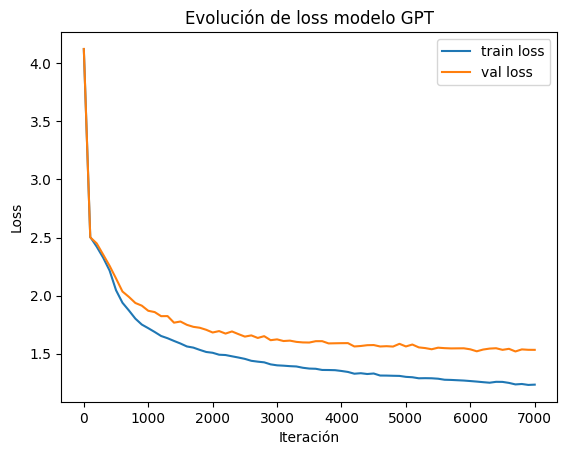

In [82]:
# Gráficar train loss y val loss
plt.plot(range(max_iters+1)[::100], train_loss_list, label='train loss')
plt.plot(range(max_iters+1)[::100], val_loss_list, label='val loss')
plt.title('Evolución de loss modelo GPT')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6. Generando secuencias de texto con el modelo

In [94]:
# Generar usando el modelo
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

print('----------------------- \n wenaso el resultado juju')

# Para escribir en un archivo
# open('output.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))


in easting: it warm ship
Set Edward'st littler; which an hear
Made sworn this cause read past our friends,
Having on their abandment
Thou knavest in mine holy king,
In many head and kings, being up is father.

CLIFFOR LAURET:
Ay, you have not ill manquet.
Here in colding his own and comfortest with his country,
To the hopier of my blood hath you.

LEONTES:
Why, soft! how his pairiesthing!

JOHN OF AUFIDIUS:

PrINCES:
News regard as her watch Has
As you'll to-make me friar,
To it most men in spee
----------------------- 
 wenaso el resultado juju


> j) (bonus) Define un training loop para el baseline (modelo bi-grama). Entrénelo usando un número similar de épocas y compare las losses y generación de texto con su modelo anterior.

In [47]:
# Defino el modelo nuevamente
m = BigramLanguageModel(vocab_size)
learning_rate = 0.001
max_iters = 7000 #5000

# Enviar a 'device'
m.to(device)

# Definir optimizador con los parámetros del modelo
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

# Guardar losses en una lista
train_loss_list_2 = []

# Iterar
for iter in range(max_iters):

  # obtener batches
  xb, yb = get_batch('train')

  # cacular logits y loss del modelo
  logits, loss = m(xb, yb)

  # Guardar loss
  train_loss_list_2.append(loss.item())

  #activar el optimizador y hacer el paso backward con el resultado de la función loss
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

In [48]:
# Generar usando el modelo
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
print('')
print('loss final:', loss.item())
print('----------------------- \n resultado mejor que en el Baseline jeje')


Yooro.
WARANCAllutothin we hanV:
3OFwonome wesbrs tal:

Yout hele.
AGof, s usshesof, GBed aneafe winser mer fa go fung,
ENouXFomyowhehCERsto &EDarthar!

OV, il in lainoQUG hate hindey hj:
CY LIxhimayoron weres Yoro an uthe m.
HAgu t.

Sk heankl-imsth havenofe be
ARCo tond:
ALoS:
Burervit,
KENI plfee d mayof hur he KI weeat,
It icivire alowifind
RLI lathearoure foweeatrd aneno MedZ&y e
My an.
CaXENESCAPr chaik,

CEvivesthe tlll t t'sthe iurey, oummsse arkntanorel d as cenelashat here'prdotith g a

loss final: 2.4767372608184814
----------------------- 
 resultado mejor que en el Baseline jeje




---

A continuación se ve el gráfico de cómo evoluciona la función de pérdida en este modelo bigrama. Notar que este gráfico toma valores de 20 en 20 (definidos por el parámetro `espaciado` que está más abajo).

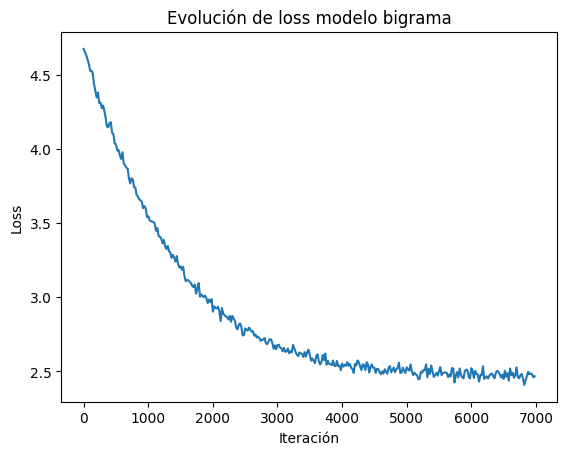

In [87]:
# Definir espaciado (espaciado=2: [0,1,2,3,4,5] ---> [0,2,4])
espaciado = 20

# Gráficar loss
plt.plot(range(max_iters)[::espaciado], train_loss_list_2[::espaciado])
plt.title('Evolución de loss modelo bigrama')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.show()

En la siguiente celda de código se ve la comparación de ambos modelos con respecto a los valores de su función de pérdida. Notar que los valores están seleccionados de manera que en cierta iteración se pueda calcular la loss de cada modelo y así poder comparar de buena forma.  
En este caso las `max_iters=7000` y se grafican 71 puntos.

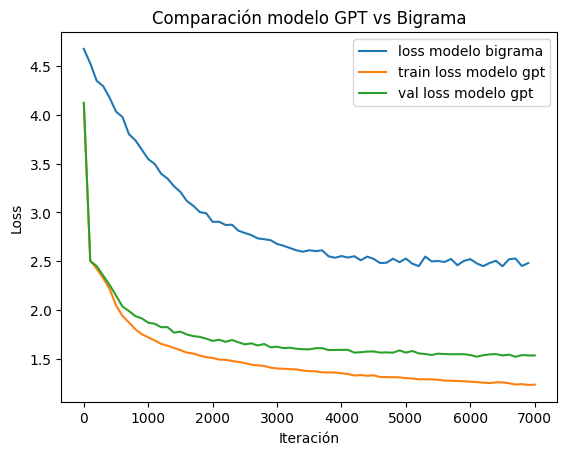

In [95]:
# Definir espaciado (espaciado=2: [0,1,2,3,4,5] ---> [0,2,4])
espaciado = 100

# Gráficar loss GPT vs Bigrama
plt.plot(range(max_iters)[::espaciado], train_loss_list_2[::espaciado], label='loss modelo bigrama')
plt.plot(range(max_iters+1)[::100], train_loss_list, label='train loss modelo gpt') # espaciado definido por max_iters / eval_interval
plt.plot(range(max_iters+1)[::100], val_loss_list, label='val loss modelo gpt') # espaciado definido por max_iters / eval_interval
plt.title('Comparación modelo GPT vs Bigrama')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.legend()
plt.show()